# Model Definition and Training

In [1]:
import numpy as np
import pandas as pd

## Import Data

In [2]:
df = pd.read_csv("C:/Users/sega9/Documents/IBM Data Science/Capstone/data/vehicles_clean.csv")

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [4]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

In [5]:
df_pd = df.drop(df.columns[0], axis=1)
df_pd.head(3)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,description_length,state,lat,long
0,mohave county,9000,2004.0,chevrolet,colorado ls,excellent,5 cylinders,gas,54000.0,clean,automatic,rwd,pickup,red,470,az,34.4783,-114.2710
1,maine,8500,2005.0,ford,mustang convertible,excellent,6 cylinders,gas,62800.0,clean,automatic,rwd,convertible,silver,718,me,44.2070,-69.7858
2,maine,2750,2006.0,chevrolet,silverado 2500hd ext cab,good,8 cylinders,gas,165000.0,clean,automatic,4wd,truck,white,280,me,43.2899,-70.8550


In [34]:
from pyspark.sql import SQLContext
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

df = sqlContext.createDataFrame(df_pd)

In [35]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml import Pipeline

In [36]:
categorical_columns= ["region", "manufacturer", "model", "condition", "cylinders",
                      "fuel", "title_status", "transmission", "drive", "type", 
                      "paint_color", "state"]

# The index of string vlaues multiple columns
indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in categorical_columns
]

# The encode of indexed values multiple columns
encoders = [OneHotEncoder(dropLast=False,inputCol=indexer.getOutputCol(),
            outputCol="{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in indexers
]

# Vectorizing encoded values
assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders],outputCol="catFeatures")

# Build pipeline of Indexer, encoder, assebler
pipeline = Pipeline(stages=indexers + encoders+[assembler])
model=pipeline.fit(df)
transformed = model.transform(df)

In [37]:
df_catFeat = transformed[["price","year","odometer","description_length","catFeatures"]]

In [38]:
vectorAssembler = VectorAssembler(inputCols=['year', 'odometer', 'description_length'],outputCol="features")
normalizer = Normalizer(inputCol="features", outputCol="features_norm", p=1.0)

pipeline = Pipeline(stages=[vectorAssembler, normalizer])
model=pipeline.fit(df_catFeat)
df_feats = model.transform(df_catFeat)

In [39]:
df_feats = df_feats.drop("year").drop("odometer").drop("description_length").drop("features")

In [40]:
vectorAssembler = VectorAssembler(inputCols=['catFeatures', 'features_norm'],outputCol="features")
df = vectorAssembler.transform(df_feats)
df = df.drop("features_norm").drop("catFeatures")
df.show(5)

+-----+--------------------+
|price|            features|
+-----+--------------------+
| 9000|(13246,[212,403,2...|
| 8500|(13246,[50,402,69...|
| 2750|(13246,[50,403,11...|
|24930|(13246,[218,412,7...|
| 3200|(13246,[218,413,4...|
+-----+--------------------+
only showing top 5 rows



In [41]:
df.printSchema()

root
 |-- price: long (nullable = true)
 |-- features: vector (nullable = true)



# Modeling

In [42]:
# Define train and test data
train_data, test_data=df.randomSplit([0.7,0.3])

## Linear Regression

In [43]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [44]:
# Define model
lr = LinearRegression(labelCol='price', maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [45]:
# Fit the model
lrModel = lr.fit(train_data)

In [58]:
# Summarize the model over the training set and print out metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("r2 on training data: %f" % trainingSummary.r2)
print("RMSE on training data: %f" % trainingSummary.rootMeanSquaredError)

numIterations: 11
r2 on training data: 0.666785
RMSE on training data: 5685.935140


In [47]:
# Test model on test data set and print out metrics
lr_predictions = lrModel.transform(test_data)
lr_predictions.show(5)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="price", metricName="r2")
print("r2 on test data = %g" % lr_evaluator.evaluate(lr_predictions))

test_result = lrModel.evaluate(test_data)
print("RMSE on test data = %g" % test_result.rootMeanSquaredError)

+-----+--------------------+------------------+
|price|            features|        prediction|
+-----+--------------------+------------------+
|  306|(13246,[103,407,1...|19345.507023652455|
|  314|(13246,[61,402,13...|21086.501840624744|
|  350|(13246,[132,416,3...| 4925.806809996933|
|  350|(13246,[168,403,4...| 8350.041183220435|
|  399|(13246,[110,403,4...| 8081.797793222678|
+-----+--------------------+------------------+
only showing top 5 rows

r2 on test data = 0.550191
RMSE on test data = 6683.25


In [115]:
# Write results to text file
text_file = open("lrModel_Output.txt", "w")
text_file.write("Linear Regression Model Results:")
text_file.write("\nr2 on training data: %f" % trainingSummary.r2)
text_file.write("\nRMSE on training data: %f" % trainingSummary.rootMeanSquaredError)

text_file.write("\nr2 on test data: %g" % lr_evaluator.evaluate(lr_predictions))
text_file.write("\nRMSE on test data: %g" % test_result.rootMeanSquaredError)
text_file.close()

In [32]:
# Save Model
lrModel.write().overwrite().save(sc,"C:/Users/sega9/Documents/IBM Data Science/Capstone/Models/linReg.model")

## Gradient Boosted Trees Regression

In [59]:
from pyspark.ml.regression import GBTRegressor

In [60]:
# Define model
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'price', maxIter=10)
gbt_model = gbt.fit(train_data)

In [61]:
gbt_predictions = gbt_model.transform(train_data)
gbt_predictions.select('prediction', 'price', 'features').show(5)

+------------------+-----+--------------------+
|        prediction|price|            features|
+------------------+-----+--------------------+
|2141.5283505721954|  300|(13246,[113,403,9...|
| 6488.882399906475|  300|(13246,[272,410,5...|
|13350.254924315772|  323|(13246,[172,403,8...|
|21466.787244145773|  334|(13246,[12,402,50...|
|29724.451495718804|  334|(13246,[183,403,6...|
+------------------+-----+--------------------+
only showing top 5 rows



In [62]:
# Summarize the model over the training set and print out metrics
gbt_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
r2 = gbt_evaluator.evaluate(gbt_predictions)
print("r2 on training data = %g" % r2)

gbt_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("RMSE on training data = %g" % rmse)

r2 on training data = 0.629928
RMSE on training data = 5992.15


In [63]:
# Test model on test data set and print out metrics
gbt_predictions = gbt_model.transform(test_data)

gbt_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
r2 = gbt_evaluator.evaluate(gbt_predictions)
print("r2 on test data = %g" % r2)

gbt_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("RMSE on test data = %g" % rmse)

r2 on test data = 0.615941
RMSE on test data = 6175.51


In [116]:
# Write results to text file
text_file = open("gbtModel_Output.txt", "w")
text_file.write("Gradient Boosted Trees Model Results:")
text_file.write("\nr2 on training data: %g" % r2)
text_file.write("\nRMSE on training data: %g" % rmse)

text_file.write("\nr2 on test data: %g" % r2)
text_file.write("\nRMSE on test data: %g" % rmse)
text_file.close()

In [38]:
# Save Model
gbt_model.write().overwrite().save(sc,"C:/Users/sega9/Documents/IBM Data Science/Capstone/Models/gbt.model")

## Deep Learning Model

In [6]:
df_pd = df_pd[[ 'price', 'year', 'odometer', 'description_length', 'lat', 'long',
         'region', 'manufacturer', 'model', 'condition',
         'cylinders', 'fuel', 'title_status', 'transmission',
         'drive', 'type', 'paint_color', 'state']]

In [7]:
# Drop columns to help processing time
# Model and region have 33701 and 403 unique values, removing these massively reduces pocessing time
df_pd = df_pd.drop(columns=['model', 'region'])

In [8]:
df_pd.head()

,price,year,odometer,description_length,lat,long,manufacturer,condition,cylinders,fuel,title_status,transmission,drive,type,paint_color,state
0,9000,2004.0,54000.0,470,34.4783,-114.2710,chevrolet,excellent,5 cylinders,gas,clean,automatic,rwd,pickup,red,az
1,8500,2005.0,62800.0,718,44.2070,-69.7858,ford,excellent,6 cylinders,gas,clean,automatic,rwd,convertible,silver,me
2,2750,2006.0,165000.0,280,43.2899,-70.8550,chevrolet,good,8 cylinders,gas,clean,automatic,4wd,truck,white,me
3,24930,2017.0,32989.0,978,45.6546,-110.5610,subaru,excellent,4 cylinders,gas,clean,automatic,4wd,SUV,grey,mt
4,3200,1998.0,98186.0,193,46.7074,-111.9580,volkswagen,good,4 cylinders,gas,clean,manual,rwd,coupe,blue,mt


### Encoding for model

In [9]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [10]:
df_pd.iloc[:,:6]

,price,year,odometer,description_length,lat,long
0,9000,2004.0,54000.0,470,34.4783,-114.2710
1,8500,2005.0,62800.0,718,44.2070,-69.7858
2,2750,2006.0,165000.0,280,43.2899,-70.8550
3,24930,2017.0,32989.0,978,45.6546,-110.5610
4,3200,1998.0,98186.0,193,46.7074,-111.9580
...,...,...,...,...,...,...
117024,6900,2008.0,210994.0,249,43.8636,-95.1138
117025,29930,2016.0,30383.0,2371,44.0805,-103.2310
117026,24900,2017.0,27100.0,736,45.6546,-110.5610
117027,46995,2019.0,55000.0,493,34.8001,-82.3932


In [11]:
le = LabelEncoder()

df_encoded = df_pd.iloc[:,6:].apply(le.fit_transform)

In [12]:
df_encoded.head()

,manufacturer,condition,cylinders,fuel,title_status,transmission,drive,type,paint_color,state
0,7,0,4,2,0,0,2,8,8,3
1,13,0,5,2,0,0,2,2,9,21
2,7,2,6,2,0,0,0,10,10,21
3,37,0,3,2,0,0,0,0,5,26
4,40,2,3,2,0,1,2,3,1,26


In [13]:
df_dummies = pd.get_dummies(data=df_encoded, columns=df_encoded.columns)

In [14]:
dfModel = pd.concat([df_pd.iloc[:,:6], df_dummies], axis=1)

In [15]:
dfModel = dfModel.drop(columns=['lat', 'long'])

In [16]:
dfModel

,price,year,odometer,description_length,manufacturer_0,manufacturer_1,manufacturer_2,manufacturer_3,manufacturer_4,manufacturer_5,...,state_41,state_42,state_43,state_44,state_45,state_46,state_47,state_48,state_49,state_50
0,9000,2004.0,54000.0,470,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8500,2005.0,62800.0,718,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2750,2006.0,165000.0,280,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,24930,2017.0,32989.0,978,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3200,1998.0,98186.0,193,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117024,6900,2008.0,210994.0,249,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
117025,29930,2016.0,30383.0,2371,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
117026,24900,2017.0,27100.0,736,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
117027,46995,2019.0,55000.0,493,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Sequential Deep Learning Model

In [17]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [18]:
from sklearn.model_selection import train_test_split

# Split data into test and train 
train, test = train_test_split(dfModel, test_size=0.3)

In [19]:
# Seperate features and targets
X_train = train.drop(columns=['price'])
Y_train = train[['price']]

X_test = test.drop(columns=['price'])
Y_test = test[['price']]

In [24]:
# Define model
model = keras.Sequential()

model.add(keras.layers.Dense(152, activation='relu', input_shape=(152,)))
model.add(keras.layers.Dense(75))
model.add(keras.layers.Dense(50))
model.add(keras.layers.Dense(1))

In [31]:
# Define model
model = keras.Sequential()

model.add(keras.layers.Dense(152, activation='selu', input_shape=(152,)))
model.add(keras.layers.Dense(75))
model.add(keras.layers.Dense(50))
model.add(keras.layers.Dense(1))

In [32]:
# Compile Model
model.compile(optimizer='Adam', loss='mean_squared_error')

In [33]:
# Fit model
model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test),
          callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Train on 81920 samples, validate on 35109 samples
Epoch 1/100
81920/81920 [==============================] - 7s 84us/step - loss: 96166071.2195 - val_loss: 67726132.6287
Epoch 2/100
81920/81920 [==============================] - 6s 74us/step - loss: 75826239.5422 - val_loss: 63653133.9721
Epoch 3/100
81920/81920 [==============================] - 6s 75us/step - loss: 64599128.5633 - val_loss: 62676145.9062
Epoch 4/100
81920/81920 [==============================] - 7s 86us/step - loss: 63364469.8699 - val_loss: 62094395.9745
Epoch 5/100
81920/81920 [==============================] - 6s 79us/step - loss: 62217631.0664 - val_loss: 61391773.1010
Epoch 6/100
81920/81920 [==============================] - 6s 77us/step - loss: 62567771.5355 - val_loss: 62341496.2748
Epoch 7/100
81920/81920 [==============================] - 6s 76us/step - loss: 61847276.1277 - val_loss: 59116196.1310
Epoch 8/100
81920/81920 [==============================] - 6s 75us/step - loss: 63613676.5477 - val_loss: 6188

In [34]:
# Evaluate model scores
scoreTest = model.evaluate(X_test, Y_test, verbose=1)
scoreTrain = model.evaluate(X_train, Y_train, verbose=1)

81920/81920 [==============================] - 2s 26us/step


In [39]:
# Save model for easy use
model.save('C:/Users/sega9/Documents/IBM Data Science/Capstone/Models/deepLearningModel.h5')

In [92]:
# Load previously run model
from keras.models import load_model
model = load_model('C:/Users/sega9/Documents/IBM Data Science/Capstone/Models/deepLearningModel.h5')

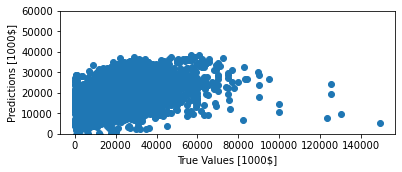

In [35]:
from matplotlib import pyplot as plt

test_predictions = model.predict(X_test).flatten()

plt.scatter(Y_test, test_predictions)
plt.xlabel('True Values [1000$]')
plt.ylabel('Predictions [1000$]')
plt.axis('scaled')
# plt.xlim(plt.xlim())
plt.ylim(bottom=0, top=60000)
_ = plt.plot([-100, 100], [-100, 100])

In [36]:
from sklearn.metrics import r2_score
train_predictions = model.predict(X_train).flatten()

# Determine r2 score for test and train data
r2Test = r2_score(Y_test, test_predictions)
r2Train = r2_score(Y_train, train_predictions)

In [114]:
# Write results to text file
text_file = open("deepLearningModel_Output.txt", "w")
text_file.write("Keras Squential Model Results:")
text_file.write("\nr2 on training data: %f" % r2Train)
text_file.write("\nRMSE on training data: %f" % np.sqrt(scoreTrain[0]))

text_file.write("\nr2 on test data: %f" % r2Test)
text_file.write("\nRMSE on test data: %f" % np.sqrt(scoreTest[0]))
text_file.close()